In [786]:
## Import all required libraries
import os
from datetime import datetime
import datetime
datetime.datetime.strptime
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.dates as mdates
import glob
import matplotlib.pyplot as plt
from functools import reduce
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from statsmodels.tools import add_constant
from statsmodels.regression import linear_model
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score

### 01. Scope Analysis: Exploration of Variables and Analysis of Redundancy

In [685]:
##Changing the working directory
os.chdir(r'D:\Interview Prep\Credit Risk Model\German_dataset')

In [686]:
df_source = pd.read_excel(r'German_Bank_Raw.xlsx')

In [687]:
##Import dataset
df = pd.read_excel(r'German_Bank_Raw.xlsx')

In [688]:
##Dataset Head
df.head(5)

,OBS,CHK_ACCT,DURATION,HISTORY,NEW_CAR,USED_CAR,FURNITURE,RADIO_TV,EDUCATION,RETRAINING,...,AGE,OTHER_INSTALL,RENT,OWN_RES,NUM_CREDITS,JOB,NUM_DEPENDENTS,TELEPHONE,FOREIGN,RESPONSE
0,1,0,6,4,0,0,0,1,0,0,...,67,0,0,1,2,2,1,1,0,1
1,2,1,48,2,0,0,0,1,0,0,...,22,0,0,1,1,2,1,0,0,0
2,3,3,12,4,0,0,0,0,1,0,...,49,0,0,1,1,1,2,0,0,1
3,4,0,42,2,0,0,1,0,0,0,...,45,0,0,0,1,2,2,0,0,1
4,5,0,24,3,1,0,0,0,0,0,...,53,0,0,0,2,2,2,0,0,0


In [689]:
##Dataset Description
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   OBS               1000 non-null   int64
 1   CHK_ACCT          1000 non-null   int64
 2   DURATION          1000 non-null   int64
 3   HISTORY           1000 non-null   int64
 4   NEW_CAR           1000 non-null   int64
 5   USED_CAR          1000 non-null   int64
 6   FURNITURE         1000 non-null   int64
 7   RADIO_TV          1000 non-null   int64
 8   EDUCATION         1000 non-null   int64
 9   RETRAINING        1000 non-null   int64
 10  AMOUNT            1000 non-null   int64
 11  SAV_ACCT          1000 non-null   int64
 12  EMPLOYMENT        1000 non-null   int64
 13  INSTALL_RATE      1000 non-null   int64
 14  MALE_DIV          1000 non-null   int64
 15  MALE_SINGLE       1000 non-null   int64
 16  MALE_MAR_or_WID   1000 non-null   int64
 17  CO_APPLICANT      1000 non-null   

###### No Null Rows in the Dataset

In [690]:
# shape of the dataset
df.shape

(1000, 32)

###### German Bank Dataset contains 1000 rows of obsevation and 32 Columns

###### 1.1 Removing the Redundant Variable 

In [691]:
df.drop(['TELEPHONE'], axis = 1, inplace = True)
# Verifying the dataset post drop operation
df_columns = len(df.columns)
print(df_columns)

31


###### Justification for Dropping Columns:
        Telephone - Existence of Telephone for the borrower does not explain origination risk associated with a borrower. Telephone is more relevant in collection model.

###### 1.2 Co-Variate Creation and Variable Summarisation

In [692]:
df['LOAN_PURPOSE'] = 0 #Others
df.loc[(df['NEW_CAR'] == 1) | (df['USED_CAR'] == 1), 'LOAN_PURPOSE'] = 1  
df.loc[(df['FURNITURE'] == 1) | (df['RADIO_TV'] == 1), 'LOAN_PURPOSE'] = 2  
df.loc[(df['EDUCATION'] == 1) | (df['RETRAINING'] == 1), 'LOAN_PURPOSE'] = 3  

df['GENDER'] = 0
df.loc[(df['MALE_DIV'] == 1) | (df['MALE_SINGLE'] == 1) | (df['MALE_MAR_or_WID'] == 1), 'GENDER'] = 1

df['RESIDENTIAL_STATUS'] = 0
df.loc[df['OWN_RES'] == 1, 'RESIDENTIAL_STATUS'] = 1
df.loc[df['RENT'] == 1, 'RESIDENTIAL_STATUS'] = 2

df['APPLICANT_TYPE'] = 0
df.loc[(df['CO_APPLICANT'] == 0) & (df['GUARANTOR'] == 0), 'APPLICANT_TYPE'] = 1

df['PROPERTY_SOURCE'] = 0
df.loc[df['REAL_ESTATE'] == 1, 'PROPERTY_SOURCE'] = 1
df.loc[df['PROP_UNKN_NONE'] == 1, 'PROPERTY_SOURCE'] = 2

In [693]:
# Dropping the primary component variables
df.drop(['NEW_CAR', 'USED_CAR', 'FURNITURE', 'RADIO_TV', 'EDUCATION', 'RETRAINING', 'MALE_DIV',
              'MALE_SINGLE', 'MALE_MAR_or_WID', 'OWN_RES', 'RENT', 'CO_APPLICANT', 'GUARANTOR',
              'REAL_ESTATE', 'PROP_UNKN_NONE'], axis=1, inplace=True)

###### Justification for Dropping Columns:
                Co-Variates for Loan_Purpose, Gender, Residential Status, Applicant Type and Property Source have been created for above dropped columns.                     

In [694]:
df.shape

(1000, 21)

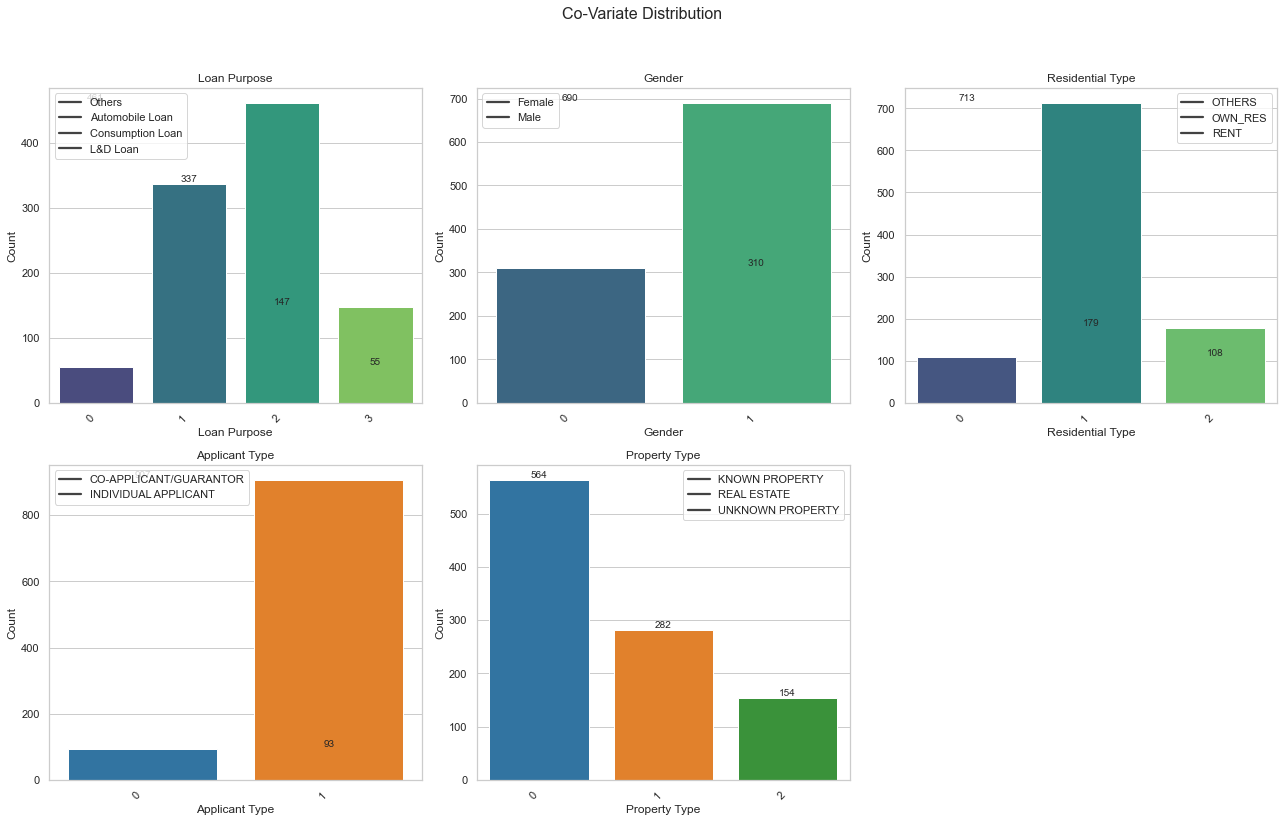

In [695]:
purpose_counts_loan = df['LOAN_PURPOSE'].value_counts()
purpose_counts_Gender = df['GENDER'].value_counts()
purpose_counts_Resi = df['RESIDENTIAL_STATUS'].value_counts()
purpose_counts_Appli = df['APPLICANT_TYPE'].value_counts()
purpose_counts_prop = df['PROPERTY_SOURCE'].value_counts()
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Co-Variate Distribution', fontsize=16)

axs[0, 0].set_title('Loan Purpose')
sns.barplot(ax=axs[0, 0], x=purpose_counts_loan.index, y=purpose_counts_loan.values, palette="viridis")
for i, count in enumerate(purpose_counts_loan.values):
    axs[0, 0].text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=10)
axs[0, 0].set_xlabel('Loan Purpose')
axs[0, 0].set_ylabel('Count')
axs[0, 0].set_xticklabels(axs[0, 0].get_xticklabels(), rotation=45, ha='right')
axs[0, 0].legend(labels=['Others', 'Automobile Loan', 'Consumption Loan', 'L&D Loan'])

axs[0, 1].set_title('Gender')
sns.barplot(ax=axs[0, 1], x=purpose_counts_Gender.index, y=purpose_counts_Gender.values, palette="viridis")
for i, count in enumerate(purpose_counts_Gender.values):
    axs[0, 1].text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=10)
axs[0, 1].set_xlabel('Gender')
axs[0, 1].set_ylabel('Count')
axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels(), rotation=45, ha='right')
axs[0, 1].legend(labels=['Female', 'Male'])

axs[0, 2].set_title('Residential Type')
sns.barplot(ax=axs[0, 2], x=purpose_counts_Resi.index, y=purpose_counts_Resi.values, palette="viridis")
for i, count in enumerate(purpose_counts_Resi.values):
    axs[0, 2].text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=10)
axs[0, 2].set_xlabel('Residential Type')
axs[0, 2].set_ylabel('Count')
axs[0, 2].set_xticklabels(axs[0, 2].get_xticklabels(), rotation=45, ha='right')
axs[0, 2].legend(labels=['OTHERS', 'OWN_RES', 'RENT'])

axs[1, 0].set_title('Applicant Type')
sns.barplot(ax=axs[1, 0], x=purpose_counts_Appli.index, y=purpose_counts_Appli.values, palette="tab10")
for i, count in enumerate(purpose_counts_Appli.values):
    axs[1, 0].text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=10)
axs[1, 0].set_xlabel('Applicant Type')
axs[1, 0].set_ylabel('Count')
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation=45, ha='right')
axs[1, 0].legend(labels=['CO-APPLICANT/GUARANTOR', 'INDIVIDUAL APPLICANT'])

axs[1, 1].set_title('Property Type')
sns.barplot(ax=axs[1, 1], x=purpose_counts_prop.index, y=purpose_counts_prop.values, palette="tab10")
for i, count in enumerate(purpose_counts_prop.values):
    axs[1, 1].text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=10)
axs[1, 1].set_xlabel('Property Type')
axs[1, 1].set_ylabel('Count')
axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=45, ha='right')
axs[1, 1].legend(labels=['KNOWN PROPERTY', 'REAL ESTATE', 'UNKNOWN PROPERTY'])
axs[1, 2].axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


###### 1.3 Explore the Expected Vs Observed Relationship of the Independent Variable with the Dependent Variable
      Defination of the Response Variable
                                         Y = 1 if the borrower is Good
                                         Y = 0 Otherwise 

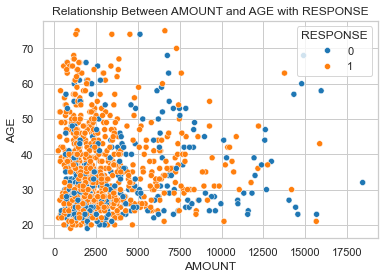

<Figure size 720x432 with 0 Axes>

In [696]:
sns.scatterplot(x='AMOUNT', y='AGE', hue='RESPONSE', data=df, palette='tab10')
plt.title('Relationship Between AMOUNT and AGE with RESPONSE')
plt.xlabel('AMOUNT')
plt.ylabel('AGE')
plt.figure(figsize=(10, 6))
plt.show()


###### 1.3.2 :Relationship Between Chk_Acct (Current Account) and Response Variable 
         Check Account has for distinct Categories
                           0 : < 0 DM
                           1 : 0 < .. <200 DM
                           2 : > 200 DM
                           3 : No checking Account

RESPONSE    0    1  Total   Sum
CHK_ACCT                       
0         135  139    274   274
1         105  164    269   269
2          14   49     63    63
3          46  348    394   394
Total     300  700   1000  1000


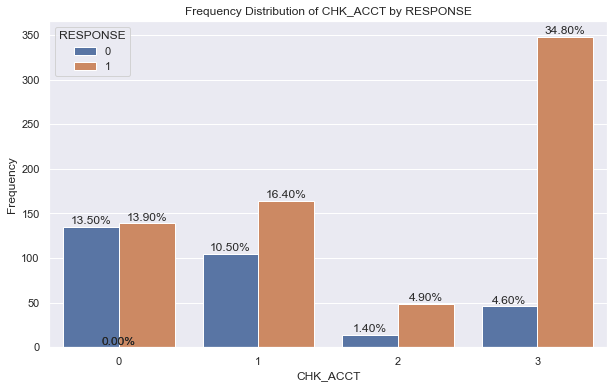

In [697]:

freq_tbl_Chck = pd.crosstab(df['CHK_ACCT'], df['RESPONSE'], margins=True, margins_name='Total')
freq_tbl_Chck['Sum'] = freq_tbl_Chck[1] + freq_tbl_Chck[0]

print(freq_tbl_Chck)
freq_tbl_Chck.drop(columns=['Total', 'Sum'], inplace=True, errors='ignore')


plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
ax = sns.countplot(data=df, x='CHK_ACCT', hue='RESPONSE')


total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3,
            f'{height / total:.2%}',
            ha='center')

plt.title('Frequency Distribution of CHK_ACCT by RESPONSE')
plt.xlabel('CHK_ACCT')
plt.ylabel('Frequency')
plt.legend(title='RESPONSE', loc='upper left')
plt.show()


###### 1.3.3 Relationship between Saving_Acct and Response Variable

###### The major categories of Savings Account are
         0: < 100 DM
         1: 100 < = .. <  500 DM
         2: 500 < = .. < 1000 DM
         3: > 1000 DM
         4: Unknown/ no savings account

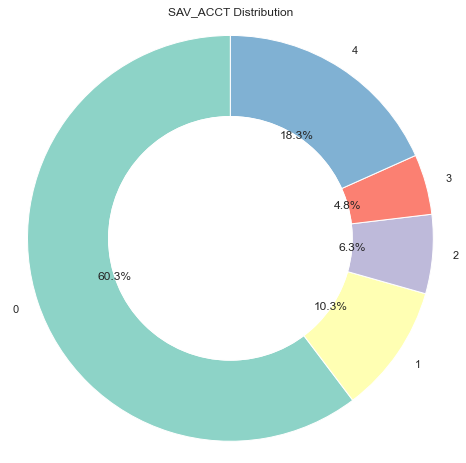

In [698]:

freq_table_Sav_Ac = pd.crosstab(df['SAV_ACCT'], df['RESPONSE'], margins=True, margins_name='Total', dropna=False)
freq_table_Sav_Ac = freq_table_Sav_Ac.drop('Total')

labels = freq_table_Sav_Ac.index
sizes = freq_table_Sav_Ac['Total'].values
colors = plt.cm.Set3.colors
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4), colors=colors)
centre_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax.axis('equal')
plt.title('SAV_ACCT Distribution')
plt.show()


In [699]:
##It is observed that Category 4 creates a break in the rank ordering of the relative bad rates.
###Borrowers who do not have a saving account are as good as borrower having Saving account = 0. 
###Therefore, we will club this category with SAV_A/C =0 which pertains to accounts with a savings balance less than 100 DM. 
###These two groups can be treated distinctly if they have a proper rank ordered relationship.

# Combining the SAV_ACCT = 0 and SAV_ACCT = 4 
df['SAV_ACCT'] = df['SAV_ACCT'].apply(lambda x: 0 if x == 0 or x == 4 else x)

df.rename(columns={'SAV_ACCT': 'SAV_ACCT'}, inplace=True)
df['SAV_ACCT'].unique()

array([0, 2, 3, 1], dtype=int64)

###### 1.4 Assessing the Actual Vs Expected Relationship between Saving Account and Bad Rates

In [700]:

freq_table = pd.crosstab(df['SAV_ACCT'], df['RESPONSE'], margins=True, margins_name='Total', dropna=False)
total_rows = freq_table.loc['Total', 'Total']
freq_table_percent = freq_table / total_rows * 100
column_names = ['Bad', 'Good', 'Total']
index_names = ['Unknown/<100 DM', '100 <= 500', '501 <= 1000 DM', '>1000 DM', 'Total']
freq_table_percent = freq_table_percent.rename(columns=dict(zip(freq_table_percent.columns, column_names)),
                                               index=dict(zip(freq_table_percent.index, index_names)))
print(freq_table_percent)

RESPONSE          Bad  Good  Total
SAV_ACCT                          
Unknown/<100 DM  24.9  53.7   78.6
100 <= 500        3.4   6.9   10.3
501 <= 1000 DM    1.1   5.2    6.3
>1000 DM          0.6   4.2    4.8
Total            30.0  70.0  100.0


Observation on Grouping:
   79% of the bad borrowers are concentrated in the category of borrowers who do not have any savings account or maintain low savings balances. Borrowers who maintained more than 100DM in their savings account balances contain only 16% of the overall bad borrowers

###### 1.5 Checking Account as a Segmentation Variable: OverDraft  Vs Non-Overdraft Segment

In [701]:
#---- CHK_ACCT AS A SEGMENTATION VARIABLE : OVERDRAFT V/S NON-OVERDRAFT SEGMENT -----
df['CURR_ACCT_STATUS'] = 0  # Default value
df.loc[df['CHK_ACCT'].isin([0, 1]), 'CURR_ACCT_STATUS'] = 1
df_result = df[['OBS', 'CHK_ACCT', 'RESPONSE', 'CURR_ACCT_STATUS']]

RESPONSE_LABEL          Bad  Good  Total
CURR_ACCT_STATUS_LABEL                  
Have Current Account    240   303    543
No Current Account       60   397    457
Total                   300   700   1000


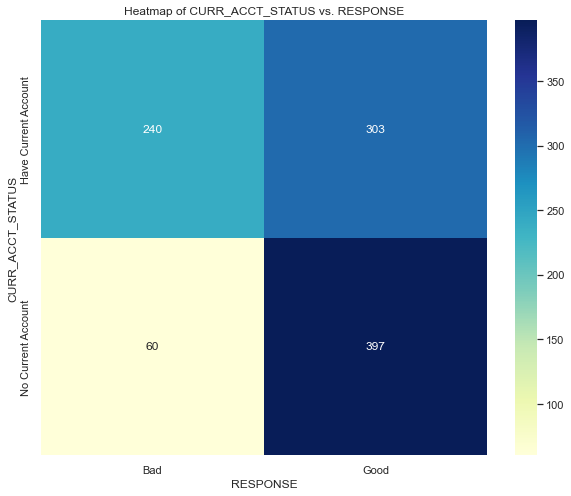

In [702]:
response_labels = {0: 'Bad', 1: 'Good'}
curr_acct_labels = {1: 'Have Current Account', 0: 'No Current Account'}

df['RESPONSE_LABEL'] = df['RESPONSE'].map(response_labels)
df['CURR_ACCT_STATUS_LABEL'] = df['CURR_ACCT_STATUS'].map(curr_acct_labels)

freq_table_CURR_ACCT_STATUS = pd.crosstab(df['CURR_ACCT_STATUS_LABEL'], df['RESPONSE_LABEL'], margins=True, margins_name='Total', dropna=False)
print(freq_table_CURR_ACCT_STATUS)
freq_table_without_total = freq_table_CURR_ACCT_STATUS.drop('Total', axis=0)
freq_table_without_total = freq_table_without_total.drop('Total', axis=1)

plt.figure(figsize=(10, 8))
sns.heatmap(freq_table_without_total, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.xlabel('RESPONSE')
plt.ylabel('CURR_ACCT_STATUS')
plt.title('Heatmap of CURR_ACCT_STATUS vs. RESPONSE')
plt.show()

###### Observation:
       1. 60% of the lending portfolio comprises of borrowers who have current account and the remaining 40% are borrowers without current account
       2.60% of the lending portfolio comprises of borrowers who have current account and the remaining 40% are borrowers without current account
       3. The segment of the borrowers who did not have a current account contains only 15% of the total number of bads, whereas the remaining 85% of the bads are concentrated in the segment of current account holders.
       
       Conclusion on Current Account Segment:
       The Current account which 'Have Current Account' Contain Relatively More Risky Borrower than Account with No Current Account. Hence, Check Account is a Potential Segmentation Variable. 

###### 1.6 Saving Account As a Segmentation Variable: Relationship Vs Non-Relationship

RESPONSE_LABEL             Bad  Good  Total
RELATIONSHIP_STATUS_LABEL                  
Non Relationship Borrower  249   537    786
Relationship Borrower       51   163    214
Total                      300   700   1000


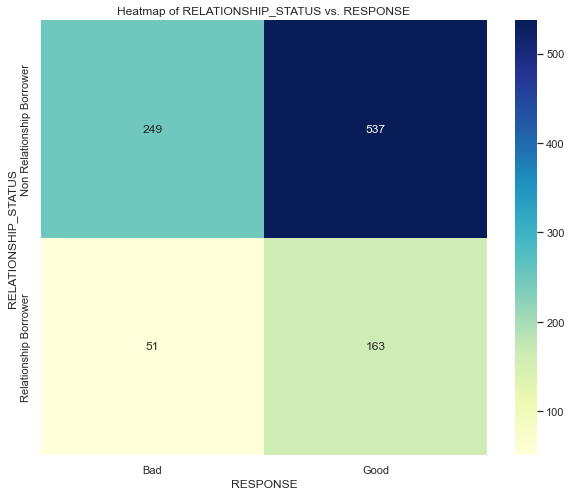

In [703]:
df['RELATIONSHIP_STATUS'] = 0  # Default value
df.loc[df['SAV_ACCT'] == 0, 'RELATIONSHIP_STATUS'] = 0
df.loc[df['SAV_ACCT'] != 0, 'RELATIONSHIP_STATUS'] = 1
df_result = df[['OBS', 'SAV_ACCT', 'RESPONSE', 'RELATIONSHIP_STATUS']]

response_labels = {0: 'Bad', 1: 'Good'}
Sav_acct_labels = {0: 'Non Relationship Borrower', 1: 'Relationship Borrower'}

df['RESPONSE_LABEL'] = df['RESPONSE'].map(response_labels)
df['RELATIONSHIP_STATUS_LABEL'] = df['RELATIONSHIP_STATUS'].map(Sav_acct_labels)

freq_table_Sav_Acct_STATUS = pd.crosstab(df['RELATIONSHIP_STATUS_LABEL'], df['RESPONSE_LABEL'], margins=True, margins_name='Total', dropna=False)
print(freq_table_Sav_Acct_STATUS)
freq_table_without_total = freq_table_Sav_Acct_STATUS.drop('Total', axis=0)
freq_table_without_total = freq_table_without_total.drop('Total', axis=1)

plt.figure(figsize=(10, 8))
sns.heatmap(freq_table_without_total, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.xlabel('RESPONSE')
plt.ylabel('RELATIONSHIP_STATUS')
plt.title('Heatmap of RELATIONSHIP_STATUS vs. RESPONSE')
plt.show()

###### Observation:
                  Non-Relationship Borrower resulted in 46% of the Defaults whereas Relationship Borrower resulted in 31% of the defaults in relationship segment. In total, Overall default was 42%. 

###### 1.7 Assessing the Association Between the Variable "History" and the Dependent Variable

RESPONSE                        0    1  Total
HISTORY                                      
All Credit Paid                28   21     49
Critical Account               50  243    293
Existing_credit_Paid/Ongoing  169  361    530
No_Credits_taken               25   15     40
delinquent                     28   60     88
Total                         300  700   1000


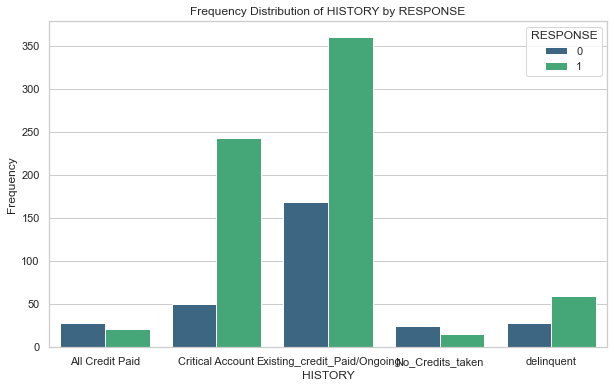

In [704]:
history_labels = {
    0: 'No_Credits_taken',
    1: 'All Credit Paid',
    2: 'Existing_credit_Paid/Ongoing',
    3: 'delinquent',
    4: 'Critical Account'
}
df['HISTORY'] = df['HISTORY'].map(history_labels)
df = df.sort_values(by='HISTORY')
freq_table_HISTORY = pd.crosstab(df['HISTORY'], df['RESPONSE'], margins=True, margins_name='Total', dropna=False)
print(freq_table_HISTORY)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.countplot(data=df, x='HISTORY', hue='RESPONSE', palette='viridis')
plt.title('Frequency Distribution of HISTORY by RESPONSE')
plt.xlabel('HISTORY')
plt.ylabel('Frequency')
plt.legend(title='RESPONSE', loc='upper right')
plt.show()

###### 1.8 Assessing the Ticket Size of Each of the Products

LOAN_PURPOSE_LABEL  AUTOMOBILES  CONSUMPTION  LEARNING DEVELOPMENT  \
mean                3768.192878  2715.114967           3825.510204   
percentile_25       1364.000000  1382.000000           1535.000000   
percentile_50       2679.000000  2136.000000           2622.000000   
percentile_75       5248.000000  3349.000000           5205.000000   

LOAN_PURPOSE_LABEL       OTHERS  
mean                3406.527273  
percentile_25       1136.000000  
percentile_50       1424.000000  
percentile_75       3659.500000  


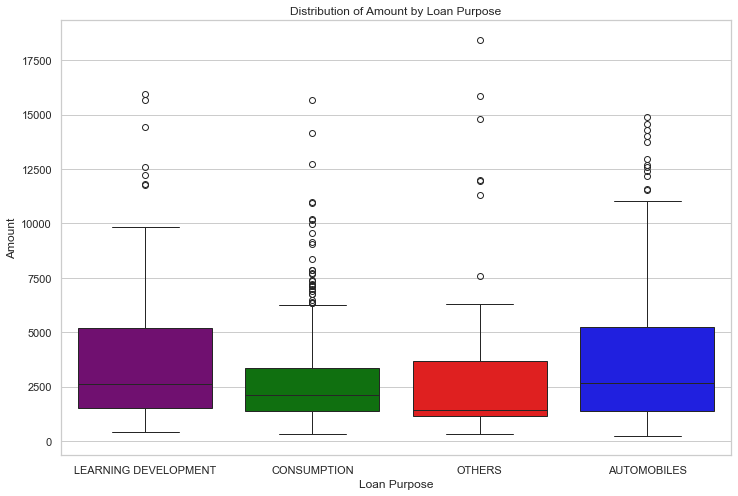

In [705]:
purpose_mapping = {
    0: 'OTHERS',
    1: 'AUTOMOBILES',
    2: 'CONSUMPTION',
    3: 'LEARNING DEVELOPMENT'
}
df['LOAN_PURPOSE_LABEL'] = df['LOAN_PURPOSE'].map(purpose_mapping)
df_temp = df[['OBS', 'AMOUNT', 'LOAN_PURPOSE_LABEL']]

def percentile_25(x):
    return np.percentile(x, 25)

def percentile_50(x):
    return np.percentile(x, 50)

def percentile_75(x):
    return np.percentile(x, 75)

agg_funcs = {
    'AMOUNT': ['mean', percentile_25, percentile_50, percentile_75]
}

pivot_table = df_temp.pivot_table(values='AMOUNT', columns='LOAN_PURPOSE_LABEL', aggfunc=agg_funcs)
print(pivot_table)
mean_amount_by_purpose = df_temp.groupby('LOAN_PURPOSE_LABEL')['AMOUNT'].mean().reset_index()
colors = {'OTHERS': 'red', 'AUTOMOBILES': 'blue', 'CONSUMPTION': 'green', 'LEARNING DEVELOPMENT': 'purple'}
plt.figure(figsize=(12, 8))
sns.boxplot(x='LOAN_PURPOSE_LABEL', y='AMOUNT', data=df_temp, palette=colors)
plt.title('Distribution of Amount by Loan Purpose')
plt.xlabel('Loan Purpose')
plt.ylabel('Amount')
plt.show()


In [706]:
loan_purpose_mapping = {
    0: 'OTHERS',
    1: 'AUTOMOBILES',
    2: 'CONSUMPTION',
    3: 'LEARNING DEVELOPMENT'
}
response_mapping = {
    0: 'Bad',
    1: 'Good'
}

df['LOAN_PURPOSE_LABEL'] = df['LOAN_PURPOSE'].map(loan_purpose_mapping)
df['RESPONSE_LABEL'] = df['RESPONSE'].map(response_mapping)
freq_table = pd.crosstab(df['LOAN_PURPOSE_LABEL'], df['RESPONSE_LABEL'], margins=True, margins_name='Total', normalize='index', dropna=False)
freq_table['Frequency'] = pd.crosstab(df['LOAN_PURPOSE_LABEL'], df['RESPONSE_LABEL'], margins=True, margins_name='Total', dropna=False).loc[:, 'Total']
print(freq_table)

RESPONSE_LABEL             Bad      Good  Frequency
LOAN_PURPOSE_LABEL                                 
AUTOMOBILES           0.314540  0.685460        337
CONSUMPTION           0.260304  0.739696        461
LEARNING DEVELOPMENT  0.380952  0.619048        147
OTHERS                0.327273  0.672727         55
Total                 0.300000  0.700000       1000


###### Observation:
         1. Nearly 80% of the total accounts in the portfolio are related to Automobiles and Consumption loans. 
         These two products collectively contribute to almost 75% of the total bad accounts
         2. There is a chance that larger defaults may occur with significant exposures,
            especially in the case of large-ticket transactions.
         3. The majority of the accounts classified as bad are primarily associated with Auto loans and Consumption Loans.
         4.The ranking of bad rates will be consistent if Auto loans and Consumption loans are the two largest ticket loans, 
           as indicated by points (ii) and (iii).

###### 1.9 Asessing the Relationship between Age and The Response Variable

In [707]:
result = df.groupby('RESPONSE')['AGE'].agg(['mean', 'max', 'min']).reset_index()
print(result)

   RESPONSE       mean  max  min
0         0  33.963333   74   19
1         1  36.224286   75   19


###### Observation :
       1.The average age of customers in the group where Y = 1 is 36, whereas the average age in the group 
         where Y= 0 is 33
       2.Consequently, we can infer that customers with a poor credit score tend to be in a younger age bracket. 
        Conducting additional tests of statistical significance will allow us to measure the statistical 
        mean difference more accurately.

###### 1.9.1 Identifying the Bad & Good Rates Over the Age Group

In [708]:
sorted_df = df.sort_values(by=['AGE'], ascending=True)

def categorize_age(age):
    if age <= 29:
        return "19-29"
    elif age <= 39:
        return "29-39"
    elif age <= 49:
        return "39-49"
    elif age <= 59:
        return "49-59"
    elif age <= 69:
        return "59-69"
    else:
        return " > 70"
    
sorted_df['Age_Group'] = sorted_df['AGE'].apply(categorize_age)
age_group_summary = sorted_df.copy()

           Age_Group
Age_Group           
 > 70              1
19-29            137
29-39             85
39-49             44
49-59             21
59-69             12


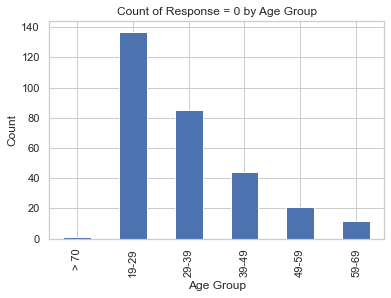

In [709]:
#Age Group Distribution when Response Variable = 0 "BAD"
filtered_data_BAD_Rate = age_group_summary[age_group_summary['RESPONSE'] == 0]
grouped_BAD_Rate = filtered_data_BAD_Rate.groupby('Age_Group').agg({'Age_Group': 'count'})
print(grouped_BAD_Rate)

grouped_BAD_Rate.plot(kind='bar', legend=False)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Count of Response = 0 by Age Group')
plt.show()

           Age_Group
Age_Group           
 > 70              6
19-29            234
29-39            245
39-49            130
49-59             53
59-69             32


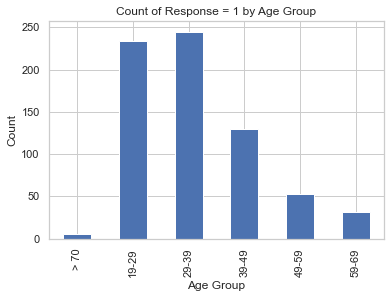

In [710]:
#Age Group Distribution when Response Variable = 1 "Good"

filtered_data_Good_Rate = age_group_summary[age_group_summary['RESPONSE'] == 1]
grouped_Good_Rate = filtered_data_Good_Rate.groupby('Age_Group').agg({'Age_Group': 'count'})
print(grouped_Good_Rate)
grouped_Good_Rate.plot(kind='bar', legend=False)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Count of Response = 1 by Age Group')
plt.show()

###### Observation:
     1. Bad rates are noted in the 19-29 age group, while conversely, good rates are also observed in the same age group.
     2. Additionally, there is a decrease in bad rates from the 19-29 age group to the 59-69 age group, indicating a 
        continuous rank ordering without a significant break.

###### 1.10 Assessing the Relationship Betwn Job Type, Year of Employment and Response Variable

<Figure size 720x432 with 0 Axes>

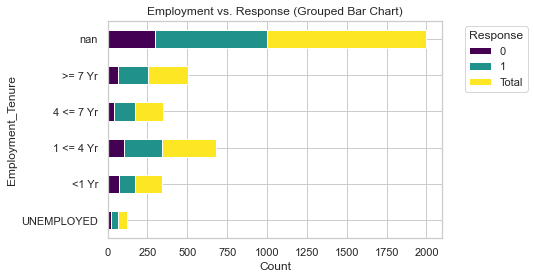

In [711]:
sorted_df_Job = df.sort_values(by=['JOB'], ascending=True)
cross_tab = pd.crosstab(index=df['EMPLOYMENT'], columns=df['RESPONSE'], margins=True, margins_name='Total', dropna=False)
grouped_cross_tab = df.groupby('JOB').apply(lambda x: pd.crosstab(index=x['EMPLOYMENT'], columns=x['RESPONSE'], margins=True, margins_name='Total', dropna=False))
grouped_cross_tab.drop('Total', axis=1, inplace=True)
employment_labels = {
    0: 'UNEMPLOYED',
    1: '<1 Yr',
    2: '1 <= 4 Yr',
    3: '4 <= 7 Yr',
    4: '>= 7 Yr'
}
Response_Label = {
 0 : 'Bad',
 1 : 'Good'
}
df['RESPONSE'] = df['RESPONSE'].map(Response_Label)
df['EMPLOYMENT'] = df['EMPLOYMENT'].map(employment_labels)
cross_tab.index = cross_tab.index.map(employment_labels)

plt.figure(figsize=(10, 6))
cross_tab.plot(kind='barh', stacked=True, cmap="viridis")
plt.title('Employment vs. Response (Grouped Bar Chart)')
plt.xlabel('Count')
plt.ylabel('Employment_Tenure')
plt.legend(title='Response', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

RESPONSE  Bad  Good  Total
JOB                       
0           7    15     22
1          56   144    200
2         186   444    630
3          51    97    148
Total     300   700   1000


<Figure size 720x432 with 0 Axes>

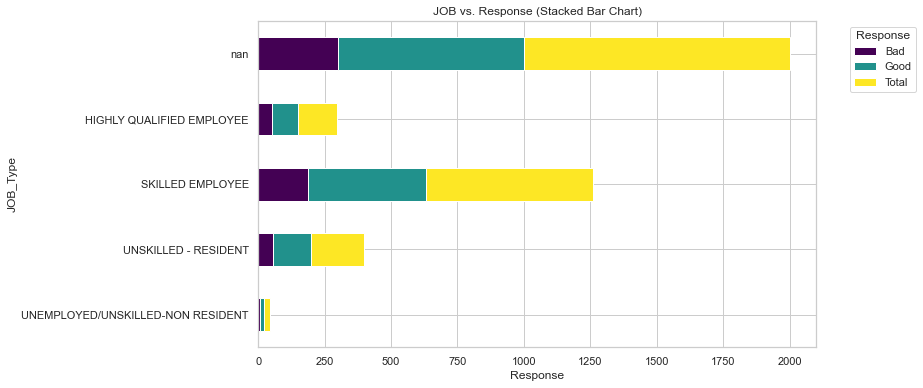

In [712]:

cross_tab_Job = pd.crosstab(index=df['JOB'], columns=df['RESPONSE'], margins=True, margins_name='Total', dropna=False)
print(cross_tab_Job)
Job_labels = {
 0 : 'UNEMPLOYED/UNSKILLED-NON RESIDENT',
 1 : 'UNSKILLED - RESIDENT',
 2 : 'SKILLED EMPLOYEE',
 3 : 'HIGHLY QUALIFIED EMPLOYEE'
}
df['JOB'] = df['JOB'].map(Job_labels)
Response_Label = {
 0 : 'Bad',
 1 : 'Good'
}
df['RESPONSE'] = df['RESPONSE'].map(Response_Label)
cross_tab_Job.index = cross_tab_Job.index.map(Job_labels)
plt.figure(figsize=(10, 6))
ax = cross_tab_Job.plot(kind='barh', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('JOB vs. Response (Stacked Bar Chart)')
plt.xlabel('Response')
plt.ylabel('JOB_Type')
plt.legend(title='Response', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

###### Observation 
       1. Job = 0: Only 2% of the overall portfolio comprises non-resident unskilled applicants. 94% of borrowers are either 
       unemployed or have a working vintage of less than 1 year. This 94% accounts for 100% of the bad accounts. 
       71% of the bads are contained in employment = 0. Loans given to unemployed, unskilled, and non-resident borrowers 
       would be very risky. Similarly, applicants with employment = 1, i.e., with experience less than a year,
       are relatively less risky, comprising about 29% of the bad borrowers. This justifies the conjecture that for a given 
       job category, a higher employment vintage increases the chances of a good borrower.

      2. Job = 1: The overall bad rate for resident unskilled borrowers (28%) is lower than for non-resident 
      unskilled applicants (31%). Unskilled borrowers have low income levels and hence lower affordability, 
      resulting in higher overall bad rates for this group. 30% of total borrowers with less than 1 year of experience 
      turned out to be bad. Similarly, the percentage of bad borrowers decreases as overall employment vintage increases. 
      Higher employment vintage leads to higher chances of a borrower being a good borrower.

     3.Job = 2, 3: These two categories are skilled applicants with much lower chances of being bad, as evident from 
     distinctly lower bad rates. However, the relative concentration of bad borrowers does not rank order for 
     some employment categories.

     4.Conclusion = One important observation across all job categories is that an employee becomes more reliable after 
     working for more than four years in a given profession. Hence, the bad rate declines in the category employment = 3,4. 
     We propose converting the employment variable into two parts: employment <= 4 years and employment > 4 years. 
     Similarly, for job type, we propose converting it into a dichotomy: job_type = skilled and job_type = unskilled.

###### 1.11 Assessing the Other Install Variable

In [713]:
df1 = df_source.copy()

In [714]:
df1['OTHER_INSTALL_Label'] = df1['OTHER_INSTALL'].map({1: 'If the borrower has other installments', 0: 'Otherwise'})
df1['RESPONSE_Label'] = df1['RESPONSE'].map({0: 'Bad', 1: 'Good'})
cross_tab = pd.crosstab(index=df1['OTHER_INSTALL_Label'], columns=df1['RESPONSE_Label'], margins=True, margins_name='Total', dropna=False)
print(cross_tab)

RESPONSE_Label                          Bad  Good  Total
OTHER_INSTALL_Label                                     
If the borrower has other installments   76   110    186
Otherwise                               224   590    814
Total                                   300   700   1000


###### Observation :

1. 81.4 % of the Overall Portfolio is Composed of Applicants who did not have any other Installment at the time of Application. Remaining 18.6% of the Portfolio is Composed of Applicants Had Other Installment Commitments. 
2. Out of the 81.4% of the Borrower who did not have any other loan commitments, Only 27.5% Turnout to be BAD as compared to the Borrower who had other Loan Commitments. 40% of the Later Type of Borrower Turned out to be BAD. 
3. The Relative distribution of BADs do not Rank Order. Out of the Total Number of 300 Bads 224 (75%) is concentrated in the Other install = 0 Segment. Other_Install = 1 Segment contains 76 Bads (25%).

**Conclude - Segment with Other_Install = 0 is relatively less risky than Segment Other_Install = 1. The Actual and the Observed relationship is similar and Aligned to Each Other. 

### 02. PORTFOLIO REVIEW AND GAP IDENTIFICATION

In [715]:
Bank_Portfolio = df_source[['OBS','AMOUNT','DURATION', 'RESPONSE']]

###### 2.0 REPORTING THE OVERALL ACCOUNTS,BALANCE AND AVERAGE BALANCES

In [716]:
### Total Receiavbles
Total_receivables = Bank_Portfolio['AMOUNT'].sum()
### Average Receiavbles
Avg_receivables = Bank_Portfolio['AMOUNT'].mean()
### Total Account
Total_Account = Bank_Portfolio['OBS'].count()
### Max DURATION
Max_Duration = Bank_Portfolio['DURATION'].max()

print("The Bank Total Receivables was",Total_receivables)
print("The Bank Average Receivables was",Avg_receivables)
print("The Bank Total Account Reported was",Total_Account)
print("The Bank Highest Duration (months) was ",Max_Duration)

The Bank Total Receivables was 3271258
The Bank Average Receivables was 3271.258
The Bank Total Account Reported was 1000
The Bank Highest Duration (months) was  72


###### Observation :
                   German Bank has total Receivable of 3.2 Million Deutschmark and Average Receivable of 3271.2 Deutschmark. Bank total accounts reported was 1000 accounts. 

###### 2.1 REPORTING THE TOTAL DURATION OF LOANS, AVERAGE DURATION OF LOANS

In [717]:
Total_Duration = Bank_Portfolio['DURATION'].sum()
Mean_Duration = Bank_Portfolio['DURATION'].mean()

print("Total Duration of Loan reported is", Total_Duration)
print("Average Duration of Loan reported is", Mean_Duration)

Total Duration of Loan reported is 20903
Average Duration of Loan reported is 20.903


##### Observation: 
               On an average a loan was given for 21 Months i.e. Slightly Less Than Two Years.

###### 2.2 DISTRIBUTION OF THE BALANCES AND ACCOUNTS BY THE BORROWER TYPES

In [718]:
## Amount Variable seggregration based on a/c, total and average
Portfolio_Summary_Amt = Bank_Portfolio.groupby('RESPONSE')['AMOUNT'].agg(
    Number_of_accounts='count',
    Total='sum',
    Average='mean'
).reset_index()

print(Portfolio_Summary_Amt)

   RESPONSE  Number_of_accounts    Total      Average
0         0                 300  1181438  3938.126667
1         1                 700  2089820  2985.457143


###### Observation on Loans Disbursed

        1. Total No. of Bads = 300
        2. Total No. of Goods = 700
        3. On an Average the borrower have been given 2985 DM Worth of Credit Whereas the Bad Borrower Hold DM 3938 
           Worth of Credit.
        4. Hence, There is an Observed Problem of adverse selection in this existent Lending Strategy. Adverse Selection  
           refers to the process of Selecting the Bad Borrowers Over Good Borrower. 

In [719]:
## Duration Variable seggregration based on a/c, total and average
Portfolio_Summary_Dur = Bank_Portfolio.groupby('RESPONSE')['DURATION'].agg(
    Number_of_accounts='count',
    Total='sum',
    Average='mean'
).reset_index()

print(Portfolio_Summary_Dur)

   RESPONSE  Number_of_accounts  Total    Average
0         0                 300   7458  24.860000
1         1                 700  13445  19.207143


###### Observation on Loan Duration 

          1. The average Loan Duration given to borrower turned bad is 2 Years. 
          2. The average Loan Duration given to borrower not defaulted is 1 Year 7 Months. 

#### It is Evident from Loan and Duration assessment that points out flaws in existent lending strategy of German Bank.

###### 2.3 DEEP DIVING INTO THE CAUSES OF THE ADVERSE SELECTION WITH AMOUNT AND DURATION

In [720]:
df2 = df_source.copy()
Total_Receivables_Summary = pd.DataFrame({
    'PCTL_': np.percentile(df2['AMOUNT'], [0, 1, 3, 5, 10, 15, 25, 50, 75, 80, 85, 90, 95, 99, 99.9, 99.99, 99.999, 100])
})

# Display the resulting DataFrame
print(Total_Receivables_Summary)

          PCTL_
0     250.00000
1     425.83000
2     638.70000
3     708.95000
4     932.00000
5    1157.55000
6    1365.50000
7    2319.50000
8    3972.25000
9    4720.00000
10   5969.95000
11   7179.40000
12   9162.70000
13  14180.39000
14  15947.47900
15  18176.34790
16  18399.23479
17  18424.00000


###### Analysing the Distribution Result

      1. PCTL_0 = 250: In the Percentile distribution there are 0% of the observation which are less than equal to 250. 
      2. PCTL_100 = 18424: In the Percentile distribution there are 100% of the observation which are less than equal to 
                           18424.

In [721]:
df2['Total_Receivables'] = pd.cut(df2['AMOUNT'],
                      bins=[float('-inf'), 1365, 2319.5, 3972.50, float('inf')],
                      labels=[0, 1, 2, 3],
                      right=False,
                      include_lowest=True)


In [722]:
cross_tab_total_receivable = pd.crosstab(index=df2['Total_Receivables'], columns=df1['RESPONSE'], margins=True, margins_name='Total', dropna=False)
print(cross_tab_total_receivable)

RESPONSE             0    1  Total
Total_Receivables                 
0                   77  173    250
1                   62  188    250
2                   56  194    250
3                  105  145    250
Total              300  700   1000


##### Observation on total_Receivables:
               1. The Percentages of borrower Turning out BAD is seen to DECREASE across amount from 0,1,2. 
               2. Rank Ordering Break is seen in amount Category 2, as observed BAD is Increasing in at 3.

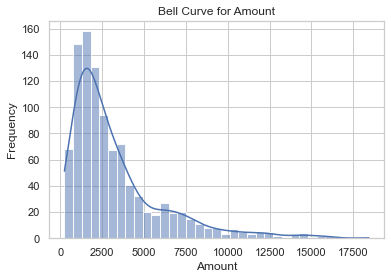

In [723]:
sns.histplot(df2['AMOUNT'], kde=True)
plt.title('Bell Curve for Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

### 3. Data Quality Checks

###### 3.0 Missing Observation Analysis

In [724]:
df3 = df_source.copy()

In [725]:
var = ['OBS', 'CHK_ACCT', 'DURATION', 'HISTORY', 'NEW_CAR', 'USED_CAR',
       'FURNITURE', 'RADIO_TV', 'EDUCATION', 'RETRAINING', 'AMOUNT',
       'SAV_ACCT', 'EMPLOYMENT', 'INSTALL_RATE', 'MALE_DIV', 'MALE_SINGLE',
       'MALE_MAR_or_WID', 'CO_APPLICANT', 'GUARANTOR', 'PRESENT_RESIDENT',
       'REAL_ESTATE', 'PROP_UNKN_NONE', 'AGE', 'OTHER_INSTALL', 'RENT',
       'OWN_RES', 'NUM_CREDITS', 'JOB', 'NUM_DEPENDENTS', 'TELEPHONE',
       'FOREIGN', 'RESPONSE']

def create_missing_flag(data, var):
    for col in var:
        data[col + '_Missing_Flag'] = data[col].isnull().astype(int)
        data['Missing_Flag'] = data[col].apply(lambda x: 1 if pd.isnull(x) else 0)

create_missing_flag(df3, var)

In [726]:
def calculate_missing_stats(data):
    missing_cols = [col for col in data.columns if 'Missing_Flag' in col]
    
    for col in missing_cols:
        count = data[col].sum()
        sum_value = data[col].sum()
        mean_value = data[col].mean()
        
        print(f"Column: {col}")
        print(f"Count: {count}")
        print(f"Sum: {sum_value}")
        print(f"Mean: {mean_value}")
        print("\n")

In [727]:
calculate_missing_stats(df3)

Column: OBS_Missing_Flag
Count: 0
Sum: 0
Mean: 0.0


Column: Missing_Flag
Count: 0
Sum: 0
Mean: 0.0


Column: CHK_ACCT_Missing_Flag
Count: 0
Sum: 0
Mean: 0.0


Column: DURATION_Missing_Flag
Count: 0
Sum: 0
Mean: 0.0


Column: HISTORY_Missing_Flag
Count: 0
Sum: 0
Mean: 0.0


Column: NEW_CAR_Missing_Flag
Count: 0
Sum: 0
Mean: 0.0


Column: USED_CAR_Missing_Flag
Count: 0
Sum: 0
Mean: 0.0


Column: FURNITURE_Missing_Flag
Count: 0
Sum: 0
Mean: 0.0


Column: RADIO_TV_Missing_Flag
Count: 0
Sum: 0
Mean: 0.0


Column: EDUCATION_Missing_Flag
Count: 0
Sum: 0
Mean: 0.0


Column: RETRAINING_Missing_Flag
Count: 0
Sum: 0
Mean: 0.0


Column: AMOUNT_Missing_Flag
Count: 0
Sum: 0
Mean: 0.0


Column: SAV_ACCT_Missing_Flag
Count: 0
Sum: 0
Mean: 0.0


Column: EMPLOYMENT_Missing_Flag
Count: 0
Sum: 0
Mean: 0.0


Column: INSTALL_RATE_Missing_Flag
Count: 0
Sum: 0
Mean: 0.0


Column: MALE_DIV_Missing_Flag
Count: 0
Sum: 0
Mean: 0.0


Column: MALE_SINGLE_Missing_Flag
Count: 0
Sum: 0
Mean: 0.0


Column: MALE_MAR_or

###### Observation:
                 There is no missing value in all variable associated with the dataset.
                 

###### 3.1 Keep-Drop Analysis for the Missing Observation Summary

In [728]:
def calculate_missing_status(data):
    missing_cols = [col for col in data.columns if 'Missing_Flag' in col]
    
    for col in missing_cols:
        count = data[col].sum()
        
        status = 'INV' if count > 0 else 'KEEP'
        
        print(f"Column: {col}")
        print(f"Count of Missing Values: {count}")
        print(f"Status: {status}")
        print("\n")
calculate_missing_status(df3)

Column: OBS_Missing_Flag
Count of Missing Values: 0
Status: KEEP


Column: Missing_Flag
Count of Missing Values: 0
Status: KEEP


Column: CHK_ACCT_Missing_Flag
Count of Missing Values: 0
Status: KEEP


Column: DURATION_Missing_Flag
Count of Missing Values: 0
Status: KEEP


Column: HISTORY_Missing_Flag
Count of Missing Values: 0
Status: KEEP


Column: NEW_CAR_Missing_Flag
Count of Missing Values: 0
Status: KEEP


Column: USED_CAR_Missing_Flag
Count of Missing Values: 0
Status: KEEP


Column: FURNITURE_Missing_Flag
Count of Missing Values: 0
Status: KEEP


Column: RADIO_TV_Missing_Flag
Count of Missing Values: 0
Status: KEEP


Column: EDUCATION_Missing_Flag
Count of Missing Values: 0
Status: KEEP


Column: RETRAINING_Missing_Flag
Count of Missing Values: 0
Status: KEEP


Column: AMOUNT_Missing_Flag
Count of Missing Values: 0
Status: KEEP


Column: SAV_ACCT_Missing_Flag
Count of Missing Values: 0
Status: KEEP


Column: EMPLOYMENT_Missing_Flag
Count of Missing Values: 0
Status: KEEP


Colu

##### Observation on missing variable:
            There is no missing value. Hence, 100% of the variables are retained back for next step of the analysis. 

###### 3.2 Differentiating the Variable into ID,Date, Categorical and Continous Variable

In [729]:
df4 = df_source.copy()

In [730]:
df4['LOAN_PURPOSE'] = 0 #Others
df4.loc[(df4['NEW_CAR'] == 1) | (df4['USED_CAR'] == 1), 'LOAN_PURPOSE'] = 1  
df4.loc[(df4['FURNITURE'] == 1) | (df4['RADIO_TV'] == 1), 'LOAN_PURPOSE'] = 2  
df4.loc[(df4['EDUCATION'] == 1) | (df4['RETRAINING'] == 1), 'LOAN_PURPOSE'] = 3  

df4['GENDER'] = 0
df4.loc[(df4['MALE_DIV'] == 1) | (df4['MALE_SINGLE'] == 1) | (df4['MALE_MAR_or_WID'] == 1), 'GENDER'] = 1

df4['RESIDENTIAL_STATUS'] = 0
df4.loc[df4['OWN_RES'] == 1, 'RESIDENTIAL_STATUS'] = 1
df4.loc[df4['RENT'] == 1, 'RESIDENTIAL_STATUS'] = 2

df4['APPLICANT_TYPE'] = 0
df4.loc[(df4['CO_APPLICANT'] == 0) & (df4['GUARANTOR'] == 0), 'APPLICANT_TYPE'] = 1

df4['PROPERTY_SOURCE'] = 0
df4.loc[df4['REAL_ESTATE'] == 1, 'PROPERTY_SOURCE'] = 1
df4.loc[df4['PROP_UNKN_NONE'] == 1, 'PROPERTY_SOURCE'] = 2

In [731]:
df4.drop(['NEW_CAR', 'USED_CAR', 'FURNITURE', 'RADIO_TV', 'EDUCATION', 'RETRAINING', 'MALE_DIV',
              'MALE_SINGLE', 'MALE_MAR_or_WID', 'OWN_RES', 'RENT', 'CO_APPLICANT', 'GUARANTOR',
              'REAL_ESTATE', 'PROP_UNKN_NONE'], axis=1, inplace=True)

In [732]:
# Apply the condition to create the new variable 'Loan_Purpose1'
df4['Loan_Purpose1'] = df4['LOAN_PURPOSE'].apply(lambda x: 3 if x in [0, 3] else x)

In [733]:
### Relationship - Accounts which either have a Current or a Saving Account with Bank
df4['Relationship_Flag'] = 1  # Initialize with 1
df4.loc[(df4['CHK_ACCT'] == 3) & (df4['SAV_ACCT'] == 4), 'Relationship_Flag'] = 0

In [734]:
## Narrowing down Loan
## 0 - Retail Loan, 1 - Motor Loan
df4['LOAN_PURPOSE_L2'] = 1  # Initialize with 1
df4.loc[df4['LOAN_PURPOSE'].isin([2, 3, 0]), 'LOAN_PURPOSE_L2'] = 0

In [735]:
# Function for Distinct Variable Category and count
columns_list = ['OBS', 'CHK_ACCT', 'DURATION', 'HISTORY', 'AMOUNT', 'SAV_ACCT',
       'EMPLOYMENT', 'INSTALL_RATE', 'PRESENT_RESIDENT', 'AGE',
       'OTHER_INSTALL', 'NUM_CREDITS', 'JOB', 'NUM_DEPENDENTS', 'TELEPHONE',
       'FOREIGN', 'RESPONSE', 'LOAN_PURPOSE', 'GENDER', 'RESIDENTIAL_STATUS',
       'APPLICANT_TYPE', 'PROPERTY_SOURCE', 'Loan_Purpose1',
       'Relationship_Flag', 'LOAN_PURPOSE_L2']

def count_categories(data, columns):
    for col in columns:
        categories_count = data[col].value_counts()
        print(f"Column: {col}")
        print("Categories and Counts:")
        print(categories_count)
        print("\n")
        
Category_Count = count_categories(df4, columns_list)
print(Category_Count)

Column: OBS
Categories and Counts:
1       1
672     1
659     1
660     1
661     1
       ..
339     1
340     1
341     1
342     1
1000    1
Name: OBS, Length: 1000, dtype: int64


Column: CHK_ACCT
Categories and Counts:
3    394
0    274
1    269
2     63
Name: CHK_ACCT, dtype: int64


Column: DURATION
Categories and Counts:
24    184
12    179
18    113
36     83
6      75
15     64
9      49
48     48
30     40
21     30
10     28
60     13
27     13
42     11
11      9
20      8
8       7
4       6
45      5
7       5
39      5
14      4
13      4
33      3
28      3
54      2
16      2
22      2
47      1
5       1
26      1
72      1
40      1
Name: DURATION, dtype: int64


Column: HISTORY
Categories and Counts:
2    530
4    293
3     88
1     49
0     40
Name: HISTORY, dtype: int64


Column: AMOUNT
Categories and Counts:
1478    3
1262    3
1258    3
1275    3
1393    3
       ..
1459    1
882     1
3758    1
1136    1
4576    1
Name: AMOUNT, Length: 921, dtype: int64


Col

In [736]:
def count_categories(data, columns):
    result_df = pd.DataFrame(columns=['Column', 'Category', 'Count'])

    for col in columns:
        categories_count = data[col].value_counts().reset_index()
        categories_count.columns = ['Category', 'Count']
        categories_count['Column'] = col
        result_df = pd.concat([result_df, categories_count], ignore_index=True)

    return result_df

# Call the function with your DataFrame and column list
result_df = count_categories(df4, columns_list)

result_df4 =  result_df.groupby('Column')['Category'].agg(
    Distinct_Category='count',
    Total='sum',
    Average='mean'
).reset_index()

print()

In [737]:
#identification flag
def determine_variable_type(row):
    if row['Distinct_Category'] <= 5:
        return "Categorical"
    else:
        return "Continuous"

result_df4['Variable_Type'] = result_df4.apply(determine_variable_type, axis=1)
print(result_df4)

                Column  Distinct_Category    Total      Average Variable_Type
0                  AGE                 53     2394    45.169811    Continuous
1               AMOUNT                921  3118140  3385.602606    Continuous
2       APPLICANT_TYPE                  2        1     0.500000   Categorical
3             CHK_ACCT                  4        6     1.500000   Categorical
4             DURATION                 33      862    26.121212    Continuous
5           EMPLOYMENT                  5       10     2.000000   Categorical
6              FOREIGN                  2        1     0.500000   Categorical
7               GENDER                  2        1     0.500000   Categorical
8              HISTORY                  5       10     2.000000   Categorical
9         INSTALL_RATE                  4       10     2.500000   Categorical
10                 JOB                  4        6     1.500000   Categorical
11        LOAN_PURPOSE                  4        6     1.500000 

## 4. Data Preparation and Model Development

In [738]:
df5 = df_source.copy()

In [739]:
Total_Receivables_Summary = pd.DataFrame({
    'PCTL_': np.percentile(df5['AMOUNT'], [0, 1, 3, 5, 10, 15, 25, 50, 75, 80, 85, 90, 95, 99, 99.9, 99.99, 99.999, 100])
})
# Display the resulting DataFrame
print(Total_Receivables_Summary)

summary = df5['AMOUNT'].describe()
print(summary)

          PCTL_
0     250.00000
1     425.83000
2     638.70000
3     708.95000
4     932.00000
5    1157.55000
6    1365.50000
7    2319.50000
8    3972.25000
9    4720.00000
10   5969.95000
11   7179.40000
12   9162.70000
13  14180.39000
14  15947.47900
15  18176.34790
16  18399.23479
17  18424.00000
count     1000.000000
mean      3271.258000
std       2822.736876
min        250.000000
25%       1365.500000
50%       2319.500000
75%       3972.250000
max      18424.000000
Name: AMOUNT, dtype: float64


##### Observation:
                 For Symmetric distibution 99.99% OF THE VALUES TO LIE WITHIN THE LIMITS OF MEAN+-3SIGMA. THE VALUES OUTSIDE THE LIMIT CAN BE TREATED AS OUTLIERS OR EXTREME VALUES. THEY CAN BE INVESTIGATED FOR FURTHER ANALYSIS

In [740]:
summary['std']
# Calculate Upper Limit
Upp_Limit = summary['mean'] + 3 * summary['std']

# Calculate Lower Limit
Low_Limit = summary['mean'] - 3 * summary['std']

# Adjust Lower Limit to be non-negative
Low_Limit1 = max(0, Low_Limit)

print(Upp_Limit)
print(Low_Limit)
print(Low_Limit1)

11739.46862788132
-5196.952627881321
0


#### Logic :- Accounts with Balances More than 11,739 DM are to be treated Outlier. So Values Above the 95th Percentile are Outlier or Extreme Values. No Extreme Values Behaviour is Observed in the Lower Tail of the Distribution. 

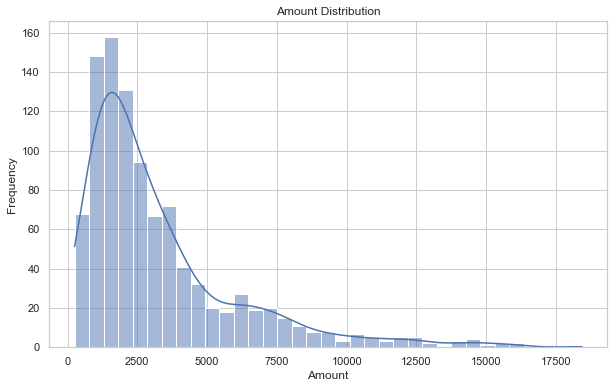

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

In [741]:
plt.figure(figsize=(10, 6))
sns.histplot(df4['AMOUNT'], kde=True)
plt.title('Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()
plt.figure(figsize=(10, 6))

In [742]:
filtered_data_chck = df5[df5['AMOUNT'] > 11739.468628]
filtered_data_chck.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 18 to 921
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   OBS               25 non-null     int64
 1   CHK_ACCT          25 non-null     int64
 2   DURATION          25 non-null     int64
 3   HISTORY           25 non-null     int64
 4   NEW_CAR           25 non-null     int64
 5   USED_CAR          25 non-null     int64
 6   FURNITURE         25 non-null     int64
 7   RADIO_TV          25 non-null     int64
 8   EDUCATION         25 non-null     int64
 9   RETRAINING        25 non-null     int64
 10  AMOUNT            25 non-null     int64
 11  SAV_ACCT          25 non-null     int64
 12  EMPLOYMENT        25 non-null     int64
 13  INSTALL_RATE      25 non-null     int64
 14  MALE_DIV          25 non-null     int64
 15  MALE_SINGLE       25 non-null     int64
 16  MALE_MAR_or_WID   25 non-null     int64
 17  CO_APPLICANT      25 non-null     i

###### Observation:
         There are 25 Observation which are outliers i.e. 2.5% of the Total Base Amount which exceeds 
         the mean+3*sigma level.

###### 4.0 Creation of the Base Data

In [743]:
df_final = df_source.copy()

In [744]:
#Base Data and Outlier Data Split
df_outlier_data = df_final[df_final['AMOUNT'] > 11739.47]
df_base_data = df_final[df_final['AMOUNT'] < 11739.47]

In [745]:
freq_table = df_base_data['RESPONSE'].value_counts(dropna=False)
percentage_table = df_base_data['RESPONSE'].value_counts(normalize=True, dropna=False) * 100

# Display frequency table
print("Frequency Table:")
print(freq_table)

# Display percentage table
print("\nPercentage Table:")
print(percentage_table)

Frequency Table:
1    692
0    283
Name: RESPONSE, dtype: int64

Percentage Table:
1    70.974359
0    29.025641
Name: RESPONSE, dtype: float64


###### Observation:
###### Overall Bad Rate 29% and Good Rate = 71%. The Removal of the Accounts have Caused the BAD Rates to Decline. 

###### 4.1 Co-Variate Creation

In [746]:
# Create the 'LOAN_PURPOSE' variable
df_base_data['LOAN_PURPOSE'] = 0 #Others
df_base_data.loc[(df_base_data['NEW_CAR'] == 1) | (df_base_data['USED_CAR'] == 1), 'LOAN_PURPOSE'] = 1  # Automobile Loan
df_base_data.loc[(df_base_data['FURNITURE'] == 1) | (df_base_data['RADIO_TV'] == 1), 'LOAN_PURPOSE'] = 2  # Consumption Loan
df_base_data.loc[(df_base_data['EDUCATION'] == 1) | (df_base_data['RETRAINING'] == 1), 'LOAN_PURPOSE'] = 3  # Learning and Development Loan

# Creating the 'GENDER' variable
df_base_data['GENDER'] = 0
df_base_data.loc[(df_base_data['MALE_DIV'] == 1) | (df_base_data['MALE_SINGLE'] == 1) | (df_base_data['MALE_MAR_or_WID'] == 1), 'GENDER'] = 1

# Creating the 'RESIDENTIAL_STATUS' variable
df_base_data['RESIDENTIAL_STATUS'] = 0
df_base_data.loc[df_base_data['OWN_RES'] == 1, 'RESIDENTIAL_STATUS'] = 1
df_base_data.loc[df_base_data['RENT'] == 1, 'RESIDENTIAL_STATUS'] = 2

# Creating the 'APPLICANT_TYPE' variable
df_base_data['APPLICANT_TYPE'] = 0
df_base_data.loc[(df_base_data['CO_APPLICANT'] == 0) & (df_base_data['GUARANTOR'] == 0), 'APPLICANT_TYPE'] = 1

# Creating the 'PROPERTY_SOURCE' variable
df_base_data['PROPERTY_SOURCE'] = 0
df_base_data.loc[df_base_data['REAL_ESTATE'] == 1, 'PROPERTY_SOURCE'] = 1
df_base_data.loc[df_base_data['PROP_UNKN_NONE'] == 1, 'PROPERTY_SOURCE'] = 2

In [747]:
# Dropping the primary component variables
df_base_data.drop(['NEW_CAR', 'USED_CAR', 'FURNITURE', 'RADIO_TV', 'EDUCATION', 'RETRAINING', 'MALE_DIV',
              'MALE_SINGLE', 'MALE_MAR_or_WID', 'OWN_RES', 'RENT', 'CO_APPLICANT', 'GUARANTOR',
              'REAL_ESTATE', 'PROP_UNKN_NONE'], axis=1, inplace=True)

In [748]:
# Creating the new variable RELATIONSHIP_STATUS
df_base_data['RELATIONSHIP_STATUS'] = 0  # Default value

# Updating RELATIONSHIP_STATUS based on SAV_ACCT values
df_base_data.loc[df_base_data['SAV_ACCT'] == 0, 'RELATIONSHIP_STATUS'] = 0
df_base_data.loc[df_base_data['SAV_ACCT'] != 0, 'RELATIONSHIP_STATUS'] = 1

In [749]:
## 0 - Retail Loan, 1 - Motor Loan
df_base_data['LOAN_PURPOSE_L2'] = 1  # Initialize with 1
df_base_data.loc[df_base_data['LOAN_PURPOSE'].isin([2, 3, 0]), 'LOAN_PURPOSE_L2'] = 0

In [750]:
# Creating the new variable CURR_ACCT_STATUS 
df_base_data['CURR_ACCT_STATUS'] = 0  # Default value

# Updating CURR_ACCT_STATUS based on CHK_ACCT values
df_base_data.loc[df_base_data['CHK_ACCT'].isin([0, 1]), 'CURR_ACCT_STATUS'] = 1

In [751]:
df_base_data.drop(['OBS'], axis=1, inplace=True)

In [752]:
df_base_data['Ran_num'] = np.random.rand(len(df_base_data))

###### 4.2 Data Split for Test & Training 

In [753]:
model_development = df_base_data[df_base_data['Ran_num'] <= 0.7]
model_validation = df_base_data[df_base_data['Ran_num'] > 0.7]

In [754]:
model_development.shape

(680, 25)

In [755]:
model_validation.shape

(295, 25)

###### 4.3 Bad Rate Distribution for Development and Validation Samples

In [756]:
# Frequency and percentage analysis for Model_Development
freq_model_development = model_development['RESPONSE'].value_counts(dropna=False)
percent_model_development = model_development['RESPONSE'].value_counts(normalize=True, dropna=False) * 100

result_model_development = pd.DataFrame({
    'Frequency': freq_model_development,
    'Percentage': percent_model_development
})

print("Frequency and Percentage analysis for Model_Development:")
print(result_model_development)

# Frequency and percentage analysis for Model_Validation
freq_model_validation = model_validation['RESPONSE'].value_counts(dropna=False)
percent_model_validation = model_validation['RESPONSE'].value_counts(normalize=True, dropna=False) * 100


result_model_validation = pd.DataFrame({
    'Frequency': freq_model_validation,
    'Percentage': percent_model_validation
})

print("\nFrequency and Percentage analysis for Model_Validation:")
print(result_model_validation)


Frequency and Percentage analysis for Model_Development:
   Frequency  Percentage
1        486   71.470588
0        194   28.529412

Frequency and Percentage analysis for Model_Validation:
   Frequency  Percentage
1        206   69.830508
0         89   30.169492


In [757]:
response_good = df_base_data[df_base_data['RESPONSE'] == 1].copy()
response_bad = df_base_data[df_base_data['RESPONSE'] != 1].copy()

In [758]:
def split_data(response_df, response):
    response_df['ran_num'] = np.random.rand(len(response_df))
    
    # Creating development and validation DataFrames
    dev_response = response_df[response_df['ran_num'] <= 0.7].copy()
    val_response = response_df[response_df['ran_num'] > 0.7].copy()
    
    # Optional: Resetting index if needed
    dev_response.reset_index(drop=True, inplace=True)
    val_response.reset_index(drop=True, inplace=True)
    
    return dev_response, val_response

In [759]:
dev_good, val_good = split_data(response_good, 'Good')
dev_bad, val_bad = split_data(response_bad, 'Bad')

In [760]:
model_development = pd.concat([dev_good, dev_bad], ignore_index=True)
model_validation = pd.concat([val_good, val_bad], ignore_index=True)

In [761]:
# Frequency and percentage analysis for Model_Development
freq_model_development = model_development['RESPONSE'].value_counts(dropna=False)
percent_model_development = model_development['RESPONSE'].value_counts(normalize=True, dropna=False) * 100

result_model_development = pd.DataFrame({
    'Frequency': freq_model_development,
    'Percentage': percent_model_development
})

print("Frequency and Percentage analysis for Model_Development:")
print(result_model_development)

# Frequency and percentage analysis for Model_Validation
freq_model_validation = model_validation['RESPONSE'].value_counts(dropna=False)
percent_model_validation = model_validation['RESPONSE'].value_counts(normalize=True, dropna=False) * 100

result_model_validation = pd.DataFrame({
    'Frequency': freq_model_validation,
    'Percentage': percent_model_validation
})

print("\nFrequency and Percentage analysis for Model_Validation:")
print(result_model_validation)

Frequency and Percentage analysis for Model_Development:
   Frequency  Percentage
1        477    70.56213
0        199    29.43787

Frequency and Percentage analysis for Model_Validation:
   Frequency  Percentage
1        215   71.906355
0         84   28.093645


###### Observation:
                Stratifying based on the response variable ensures that the distribution of bad rates in
                both the development and validation samples is more reflective of the overall
                population's Good/bad rate. Intially, at the pre-processing level, It is 70% Good and 30% Bad. 

###### 4.4  Test of Significance

In [762]:
def chi_square_test(df, variable, response_variable):
    contingency_table = pd.crosstab(df[variable], df[response_variable])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

    significance = "significant" if p_value < 0.05 else "not significant"

    result_dict = {
        'Variable': [variable],
        'Chi2 Statistic': [chi2_stat],
        'P-value': [p_value],
        'Degrees of Freedom': [dof],
        'Significance': [significance]
    }

    result_df = pd.DataFrame(result_dict)

    return result_df


Var = ['CHK_ACCT', 'DURATION', 'HISTORY', 'SAV_ACCT', 'EMPLOYMENT',
       'INSTALL_RATE', 'PRESENT_RESIDENT', 'OTHER_INSTALL',
       'NUM_CREDITS', 'JOB', 'NUM_DEPENDENTS', 'FOREIGN',
       'LOAN_PURPOSE', 'GENDER', 'RESIDENTIAL_STATUS',
       'APPLICANT_TYPE', 'PROPERTY_SOURCE', 'RELATIONSHIP_STATUS',
       'LOAN_PURPOSE_L2', 'CURR_ACCT_STATUS']

response_variable = 'RESPONSE'

results_df = pd.DataFrame()

# Iterate through variables and perform the Chi-square test
for variable in Var:
    result_df = chi_square_test(model_development, variable, response_variable)
    results_df = pd.concat([results_df, result_df], ignore_index=True)

results_df['Significance'] = results_df['P-value'].apply(lambda p: "significant" if p < 0.05 else "not significant")

pivot_table = results_df.pivot_table(index='Variable', values=['Chi2 Statistic', 'P-value', 'Degrees of Freedom', 'Significance'],
                                     aggfunc={'Chi2 Statistic': 'mean', 'P-value': 'mean', 'Degrees of Freedom': 'mean', 'Significance': lambda x: x.iloc[0]})
print(pivot_table)


                     Chi2 Statistic  Degrees of Freedom       P-value  \
Variable                                                                
APPLICANT_TYPE             1.296532                   1  2.548477e-01   
CHK_ACCT                  91.491678                   3  1.047458e-19   
CURR_ACCT_STATUS          79.370336                   1  5.149348e-19   
DURATION                  63.050886                  31  5.808631e-04   
EMPLOYMENT                15.434142                   4  3.880514e-03   
FOREIGN                    2.317991                   1  1.278851e-01   
GENDER                     7.781353                   1  5.278825e-03   
HISTORY                   41.708459                   4  1.917162e-08   
INSTALL_RATE               5.599482                   3  1.328081e-01   
JOB                        2.035307                   3  5.651111e-01   
LOAN_PURPOSE               3.910097                   3  2.713371e-01   
LOAN_PURPOSE_L2            0.001361                

###### Observation:
            As per Chi- Square analysis, following Variable are not significant, Applicant Type, Foreign, Install Rate, Job, Loan Purpose L2, Num Credit, No. of Dependent, Present Resident Etc.

In [763]:
model_development.drop(['TELEPHONE','Ran_num', 'ran_num'], inplace= True, axis=1)

###### 4.5 Information Value and Weight of Evidence 

In [764]:
German_Bank_data_Base = pd.DataFrame(model_development)
variable_names = German_Bank_data_Base.columns.tolist()
WOE_IV_Variable_List = pd.DataFrame({'Name': variable_names})
print(WOE_IV_Variable_List)

                   Name
0              CHK_ACCT
1              DURATION
2               HISTORY
3                AMOUNT
4              SAV_ACCT
5            EMPLOYMENT
6          INSTALL_RATE
7      PRESENT_RESIDENT
8                   AGE
9         OTHER_INSTALL
10          NUM_CREDITS
11                  JOB
12       NUM_DEPENDENTS
13              FOREIGN
14             RESPONSE
15         LOAN_PURPOSE
16               GENDER
17   RESIDENTIAL_STATUS
18       APPLICANT_TYPE
19      PROPERTY_SOURCE
20  RELATIONSHIP_STATUS
21      LOAN_PURPOSE_L2
22     CURR_ACCT_STATUS


In [765]:
exclude_variables = ["AGE", "AMOUNT","DURATION", "RESPONSE"]
filtered_variables = WOE_IV_Variable_List[~WOE_IV_Variable_List['Name'].isin(exclude_variables)]

In [766]:
def calculate_woe_iv(data, var, response_col='RESPONSE'):
    df = data[[var, response_col]].copy()
    total_good = df[df[response_col] == 1].shape[0]
    total_bad = df[df[response_col] == 0].shape[0]

    # Calculate WOE and IV
    woe_iv_summary = pd.DataFrame(columns=['VARNAME', 'CATEGORY', 'GOOD', 'BAD', 'WOE', 'IV'])
    
    for category in df[var].unique():
        subset = df[df[var] == category]
        good = subset[subset[response_col] == 1].shape[0]
        bad = subset[subset[response_col] == 0].shape[0]

        # Check for division by zero
        if total_good == 0 or total_bad == 0 or good == 0 or bad == 0:
            woe = 0
            diff_good_bad_dist = 0
            iv_category = 0
        else:
            woe = np.log((good / total_good) / (bad / total_bad))
            diff_good_bad_dist = (good / total_good) - (bad / total_bad)
            iv_category = diff_good_bad_dist * woe

        woe_iv_summary = woe_iv_summary.append({
            'VARNAME': var,
            'CATEGORY': category,
            'GOOD': good,
            'BAD': bad,
            'WOE': woe,
            'IV': iv_category
        }, ignore_index=True)

    return woe_iv_summary

# Iterate through variables and calculate WOE and IV
woe_iv_summary_list = []
for var in filtered_variables['Name']:
    woe_iv_summary_list.append(calculate_woe_iv(German_Bank_data_Base, var))

woe_iv_summary_combined = pd.concat(woe_iv_summary_list, ignore_index=True)
iv_summary = woe_iv_summary_combined.groupby('VARNAME')['IV'].sum().reset_index()
iv_summary['IV'] = iv_summary['IV'].round(2)

In [767]:
#function to determine variable acceptance/rejection decision
def determine_pred_capacity(iv):
    if iv < 0.03:
        return "NOT_PREDICTIVE"
    elif iv < 0.10:
        return "PREDICTIVE"
    else:
        return "HIGHLY_PREDICTIVE"

iv_summary['Pred_Capacity'] = iv_summary['IV'].apply(determine_pred_capacity)
print(iv_summary)

                VARNAME    IV      Pred_Capacity
0        APPLICANT_TYPE  0.01     NOT_PREDICTIVE
1              CHK_ACCT  0.72  HIGHLY_PREDICTIVE
2      CURR_ACCT_STATUS  0.65  HIGHLY_PREDICTIVE
3            EMPLOYMENT  0.11  HIGHLY_PREDICTIVE
4               FOREIGN  0.03         PREDICTIVE
5                GENDER  0.06         PREDICTIVE
6               HISTORY  0.29  HIGHLY_PREDICTIVE
7          INSTALL_RATE  0.04         PREDICTIVE
8                   JOB  0.02     NOT_PREDICTIVE
9          LOAN_PURPOSE  0.03         PREDICTIVE
10      LOAN_PURPOSE_L2  0.00     NOT_PREDICTIVE
11          NUM_CREDITS  0.00     NOT_PREDICTIVE
12       NUM_DEPENDENTS  0.00     NOT_PREDICTIVE
13        OTHER_INSTALL  0.12  HIGHLY_PREDICTIVE
14     PRESENT_RESIDENT  0.01     NOT_PREDICTIVE
15      PROPERTY_SOURCE  0.09         PREDICTIVE
16  RELATIONSHIP_STATUS  0.10  HIGHLY_PREDICTIVE
17   RESIDENTIAL_STATUS  0.10  HIGHLY_PREDICTIVE
18             SAV_ACCT  0.16  HIGHLY_PREDICTIVE


###### Observation:
                  Information Value less than 0.03 is Categorised as 'Non-Predictive' and Information Value greater 0.03 but less than 0.10 is Categoried as "Predictive" and IV Value greater than 0.10 is Marked with "High Predictive" Etc. As per analysis, Check Account Variable is highly Scored and has IV value of 0.64.  

###### 4.6 Logistic Regression 

In [768]:
model_development.drop(['APPLICANT_TYPE','JOB','LOAN_PURPOSE_L2','NUM_CREDITS','NUM_DEPENDENTS','PRESENT_RESIDENT'], inplace= True, axis=1)

In [769]:
mod_vars = ['CHK_ACCT', 'DURATION', 'HISTORY', 'AMOUNT', 'SAV_ACCT', 'EMPLOYMENT',
       'INSTALL_RATE', 'AGE', 'OTHER_INSTALL', 'FOREIGN', 'RESPONSE',
       'LOAN_PURPOSE', 'GENDER', 'RESIDENTIAL_STATUS', 'PROPERTY_SOURCE',
       'RELATIONSHIP_STATUS', 'CURR_ACCT_STATUS']

In [770]:
X = add_constant(model_development[mod_vars[:-1]])
y = model_development['RESPONSE']

In [771]:
model = LogisticRegression(penalty='l1', solver='liblinear')
result = model.fit(X, y)
print(result.coef_)

[[ 0.00000000e+00  0.00000000e+00 -4.35778767e-02  0.00000000e+00
  -1.14278631e-04  0.00000000e+00  0.00000000e+00 -3.92862029e-01
  -6.24687767e-02  0.00000000e+00  0.00000000e+00  1.17125442e+01
  -8.82331126e-02  0.00000000e+00 -2.74190569e-01  0.00000000e+00
   0.00000000e+00]]


In [772]:
X = add_constant(X[mod_vars[:-1]])

# Predict the response variable for the test set
y_pred = result.predict(X)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y, y_pred_binary)

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 100.00%


###### 4.7 precision, recall, and F1 score in Model Development Dataset

In [773]:
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [774]:
cm = confusion_matrix(y, y_pred_binary)
print(f"Confusion Matrix:\n{cm}")

Confusion Matrix:
[[199   0]
 [  0 477]]


###### 4.8 # ROC Curve and AUC in Model Development Dataset

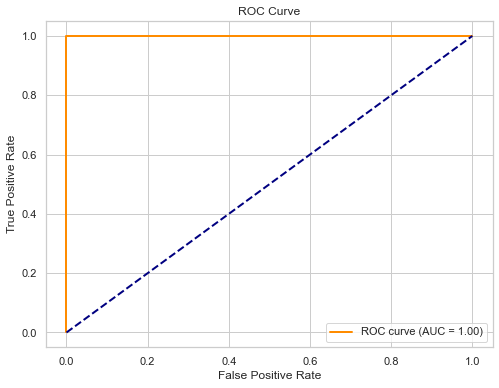

In [775]:
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

###### 4.9 Logistic Regression in Model Validation Dataset

In [776]:
model_validation.drop(['APPLICANT_TYPE','JOB','LOAN_PURPOSE_L2','NUM_CREDITS','NUM_DEPENDENTS','PRESENT_RESIDENT','Ran_num', 'ran_num','TELEPHONE'], inplace= True, axis=1)

In [777]:
model_validation.columns

Index(['CHK_ACCT', 'DURATION', 'HISTORY', 'AMOUNT', 'SAV_ACCT', 'EMPLOYMENT',
       'INSTALL_RATE', 'AGE', 'OTHER_INSTALL', 'FOREIGN', 'RESPONSE',
       'LOAN_PURPOSE', 'GENDER', 'RESIDENTIAL_STATUS', 'PROPERTY_SOURCE',
       'RELATIONSHIP_STATUS', 'CURR_ACCT_STATUS'],
      dtype='object')

In [779]:
mod_vars_v_selc = ['CHK_ACCT', 'DURATION', 'HISTORY', 'AMOUNT', 'SAV_ACCT', 'EMPLOYMENT',
                        'INSTALL_RATE', 'AGE', 'OTHER_INSTALL', 'FOREIGN',
                     'LOAN_PURPOSE', 'GENDER', 'RESIDENTIAL_STATUS', 'PROPERTY_SOURCE',
                      'RELATIONSHIP_STATUS', 'CURR_ACCT_STATUS']

# Logistic Regression
X = add_constant(model_validation[mod_vars_v_selc[:-1]])
y = model_validation['RESPONSE']

model_logistic = LogisticRegression()
result_logistic = model_logistic.fit(X, y)

# Output predicted probabilities and ROC summary
model_validation['predicted'] = result_logistic.predict_proba(X)[:, 1]
roc_summary_dev = pd.DataFrame({'Response': model_validation['RESPONSE'], 'Predicted': model_validation['predicted']})

# OLS Regression for VIF calculation
X_ols = add_constant(model_validation[mod_vars_v_selc[:-1]])
y_ols = model_validation['RESPONSE']

model_ols = linear_model.OLS(y_ols, X_ols)
result_ols = model_ols.fit()

# Calculate VIF
vif = 1 / (1 - result_ols.rsquared)
print(f"VIF: {vif}")

# Display model summary
print(result_ols.summary())

VIF: 1.2789967253811845
                            OLS Regression Results                            
Dep. Variable:               RESPONSE   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     5.264
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           2.73e-09
Time:                        19:37:40   Log-Likelihood:                -148.36
No. Observations:                 299   AIC:                             328.7
Df Residuals:                     283   BIC:                             387.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const     

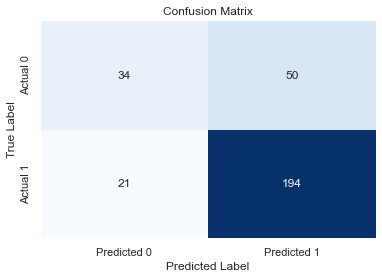

Model Accuracy: 76.25%


In [794]:
predicted_classes = (model_validation['predicted'] > 0.5).astype(int)
accuracy = accuracy_score(model_validation['RESPONSE'], predicted_classes)


# Confusion Matrix
conf_matrix = confusion_matrix(model_validation['RESPONSE'], predicted_classes)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(f"Model Accuracy: {accuracy * 100:.2f}%")

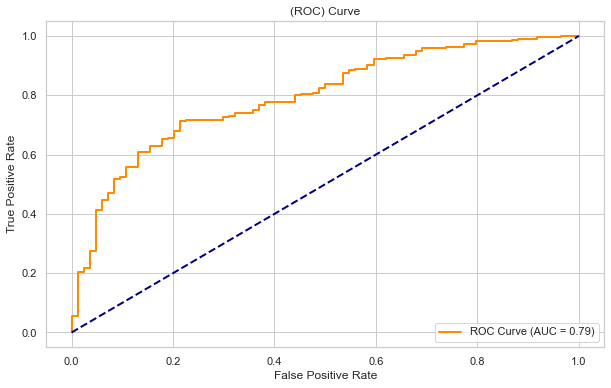

In [795]:
roc_summary_dev = pd.DataFrame({'Response': model_validation['RESPONSE'], 'Predicted': model_validation['predicted']})

# ROC Curve
fpr, tpr, thresholds = roc_curve(roc_summary_dev['Response'], roc_summary_dev['Predicted'])
roc_auc = roc_auc_score(roc_summary_dev['Response'], roc_summary_dev['Predicted'])

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve')
plt.legend(loc='lower right')
plt.show()